<a href="https://www.kaggle.com/code/jaymanvirk/bbc-news-classification-matrix-factorization-vs-s?scriptVersionId=145628788" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## BBC News Classification: Matrix Factorization vs Supervised Learning

**Jay Manvirk (Ivan Loginov)**<br/>University of Colorado, Boulder<br/>jay.manvirk@gmail.com

### Table of Contents

1. [Abstract](#abstract)
2. [Introduction](#introduction)
3. [Libraries and raw data](#libraries_data)
    - 3.1 [Libraries](#libraries)
    - 3.2 [Raw data](#raw_data)
4. [Exploratory Data Analysis](#eda)
    - 4.1 [Short Datasets Summary](#short_summary)
    - 4.2 [Number of Articles per Category](#articles_per_category)
    - 4.3 [Word Frequencies](#word_frequencies)
5. [Data Preprocessing](#data_preprocessing)
    - 5.1 [Text Cleaning](#text_cleaning)
    - 5.2 [TF-IDF Vectorization](#tfidf_vectorization)
6. [Data Modelling](#data_modelling)
    - 6.1 [Unsupervised Learning (NMF)](#ul_nmf)
    - 6.2 [Supervised Learning (SL)](#sl)
7. [Model Results Comparison between NMF and SL](#comparison)
8. [Submission Results](#submission_results)
9. [Conclusion](#conclusion)
10. [References](#references)

### 1. Abstract <a class="anchor" id="abstract"></a>

This study presents a fraction of an analysis of a BBC News dataset, encompassing Exploratory Data Analysis (EDA) and preprocessing stages, followed by a performance comparison of Non-Negative Matrix Factorization (NMF) against various supervised learning (SL) algorithms. The dataset comprises articles' texts and their categories: business, sport, tech, politics and entartainment.

The results of this study showed that SL algorithms such as SVM and Random Forest (RF) scored better than NMF in terms of accuracy, but were completely outperformed by NMF in terms of computational speed.

The presented stages in this project are supposed to provide insights into how to run EDA, preprocess data and finally the suitability of NMF as a dimensionality reduction method compared to traditional supervised learning algorithms. This notebook serves as a light guide for data science enthusiasts aiming to tackle similar tasks.

### 2. Introduction <a class="anchor" id="introduction"></a>

In this notebook we're going to look a bit closer at the model performance comparison between:
* Unsupervised Learning algorithm, concretely Non-Negative Matrix Factorization
* Supervised Learning algorithms: Logistic Regression, Random Forest and SVM

The choice of SL algorithms as well as model parameters is arbitrary and is mostly based on:
* the default values from packages' documentation
* the arbitrary minimum of top basic SL models among other NLP kernels on Kaggle

The notebook is divided into several sections in order to evaluate final comparison of models.
* **EDA:**<br/>
    Couple of major visualizations to understand the distribution of number of articles per category and frequencies of words. With that we can have an idea whether to even the number of articles per category or to remove stopwords and other characters which do not carry much information about article's class.
* **Preprocess data for modelling:**<br/>
    Tokenization, lemmatization, stopwords removal. We're going to remove stopwords, convert texts into word-tokens and then convert those word-tokens to their base form. All of that is to improve model's performance and reduce training time.
* **Unsupervised learning, NMF:**<br/>
    NMF training based on the preprocessed text using several different parameters to choose the best one for later comparison with the SL. Mean accuracy scores computation via 5-fold cross validation.
* **Supervised learning:**<br/>
    Selection of the aforementioned SL algorithms and their training on the preprocessed data using different parameters as in the previous section. Mean accuracy scores computation via 5-fold cross validation.
* **Comparison between NMF and SL:**<br/>
    Final comparison is going to be presented as a table with models' accuracy scores and their runtime.

### 3. Libraries and data <a class="anchor" id="libraries_data"></a>

#### 3.1 Libraries <a class="anchor" id="libraries"></a>

In [1]:
# basics
import numpy as np
import itertools
import os

# EDA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data preprocessing
import re
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

# Unsupervised learning
from sklearn.decomposition import NMF

# Supervised learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# helper functions
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import GridSearchCV

#### 3.2 Raw Data <a class="anchor" id="raw_data"></a>

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/learn-ai-bbc/BBC News Train.csv
/kaggle/input/learn-ai-bbc/BBC News Sample Solution.csv
/kaggle/input/learn-ai-bbc/BBC News Test.csv


In [33]:
train_data = pd.read_csv("/kaggle/input/learn-ai-bbc/BBC News Train.csv")
test_data = pd.read_csv("/kaggle/input/learn-ai-bbc/BBC News Test.csv")
sample_data = pd.read_csv("/kaggle/input/learn-ai-bbc/BBC News Sample Solution.csv")

### 4. Exploratory Data Analysis <a class="anchor" id="eda"></a>

#### 4.1 Short Datasets Summary <a class="anchor" id="short_summary"></a>

In [4]:
def print_short_summary(name, data):
    """
    Prints data head, shape and info.
    Args:
        name (str): name of dataset
        data (dataframe): dataset in a pd.DataFrame format
    """
    print(name)
    print('\n1. Data head:')
    print(data.head())
    print('\n2. Data shape: {}'.format(data.shape))
    print('\n3. Data info:')
    data.info()

In [5]:
print_short_summary('Train dataset', train_data)

Train dataset

1. Data head:
   ArticleId                                               Text  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  business
1        154  german business confidence slides german busin...  business
2       1101  bbc poll indicates economic gloom citizens in ...  business
3       1976  lifestyle  governs mobile choice  faster  bett...      tech
4        917  enron bosses in $168m payout eighteen former e...  business

2. Data shape: (1490, 3)

3. Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


In [6]:
print_short_summary('Test dataset',test_data)

Test dataset

1. Data head:
   ArticleId                                               Text
0       1018  qpr keeper day heads for preston queens park r...
1       1319  software watching while you work software that...
2       1138  d arcy injury adds to ireland woe gordon d arc...
3        459  india s reliance family feud heats up the ongo...
4       1020  boro suffer morrison injury blow middlesbrough...

2. Data shape: (735, 2)

3. Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB


In [7]:
print_short_summary('Sample dataset',sample_data)

Sample dataset

1. Data head:
   ArticleId       Category
0       1018          sport
1       1319           tech
2       1138       business
3        459  entertainment
4       1020       politics

2. Data shape: (735, 2)

3. Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Category   735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB


#### 4.2 Number of Articles per Category <a class="anchor" id="articles_per_category"></a>

We can see that the number of articles per category doesn't vary much, which makes the training dataset somewhat balanced. Otherwise, we would have needed to either even the number of articles by reducing the sample size of categories or by choosing models which are kind of immune to the imbalanced dataset alongside with more relevant metrics such as F1-score or AUC.

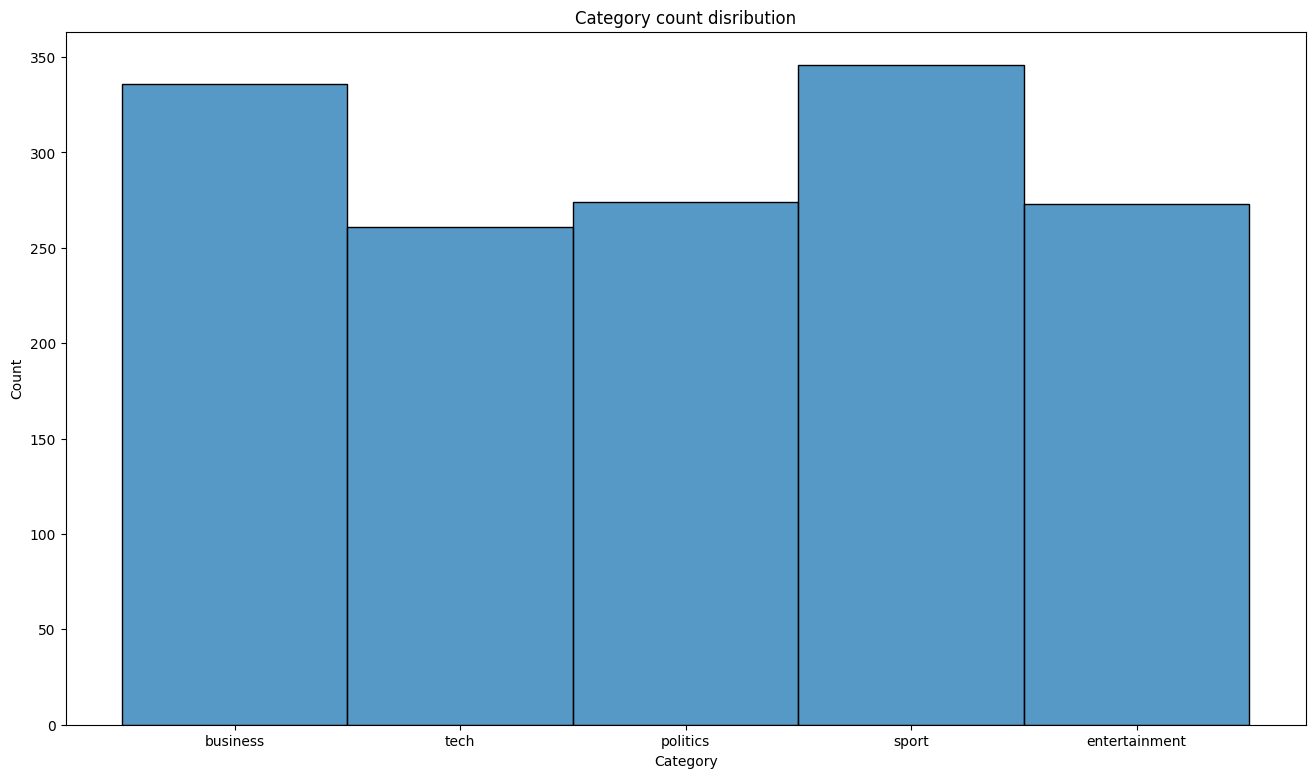

In [8]:
# Plot histogram of number of articles per category
plt.figure(figsize=(16, 9))
sns.histplot(train_data, x = 'Category')
plt.title('Category count disribution')
plt.show()

#### 4.3 Word Frequencies <a class="anchor" id="word_frequencies"></a>

Here we're going to examine texts closer on the matter of word importance. Prepositions, atricles, conjuctions can be considered irrelevant in determining category. From the text below it's also seen that apostrophes have been replaced be space leaving single letters untethered. These single words can be discarded in model training as well for the same reason of insignificance.

In [8]:
# Print category and text as an example
print('Category: {}\n'.format(train_data['Category'][0]))
print('Text:\n{}'.format(train_data['Text'][0]))

Category: business

Text:
worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to the procedures and practices

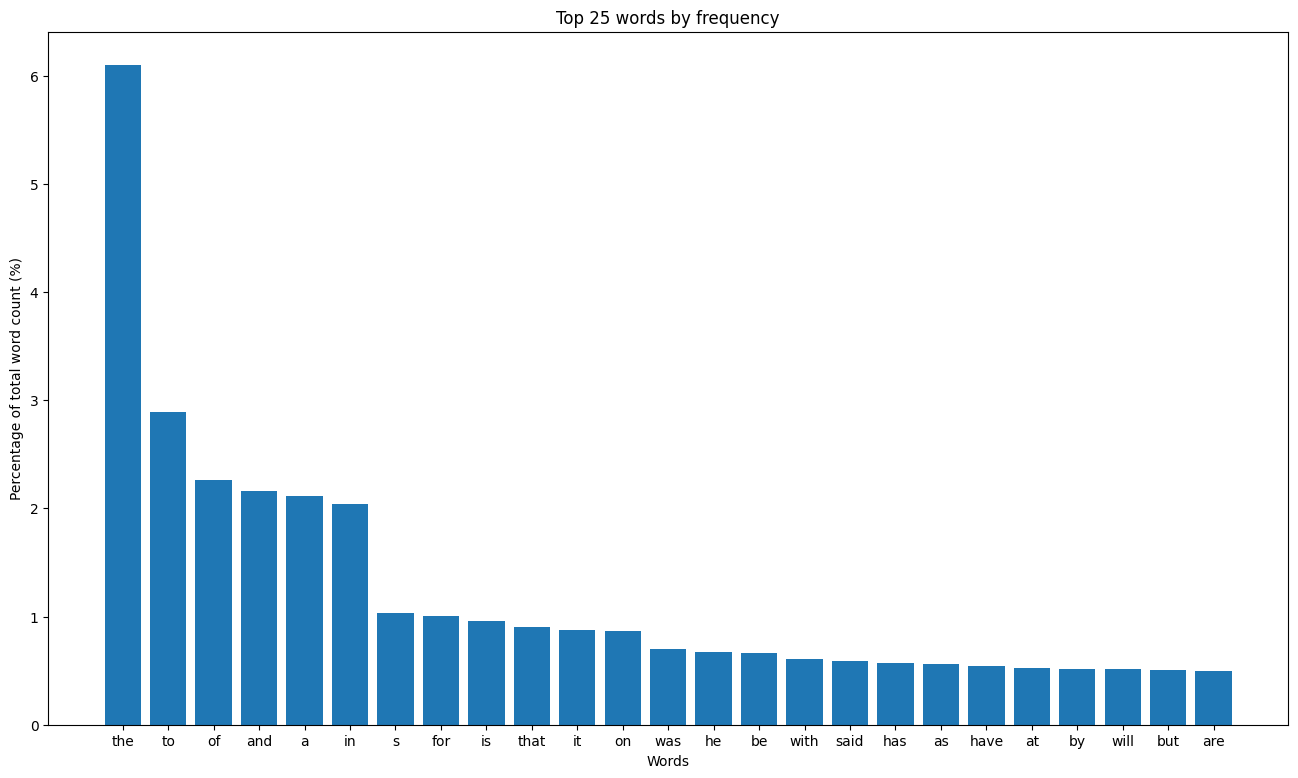

In [9]:
# Plot top 25 words by frequency
w = train_data['Text'].str.split(expand=True).unstack().value_counts()
l = w[:25]/np.sum(w)*100
plt.figure(figsize=(16,9))
plt.bar(l.index, l.values)
plt.xlabel('Words')
plt.ylabel('Percentage of total word count (%)')
plt.title('Top 25 words by frequency')
plt.show()

#### 5. Data Preprocessing <a class="anchor" id="data_preprocessing"></a>

#### 5.1 Text Cleaning <a class="anchor" id="text_cleaning"></a>

In [10]:
# Load English dataset of lemmas and stopwords
sp_process = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words('english'))

In [11]:
def get_clean_text(text):
    """
    Returns lemmatized text without single letters and digits in lower case.
    Args:
        text (str): text of an article
    Returns:
        text (str): cleand text
    """
    # Convert to lowercase
    text = text.lower()
    # Replace digits and single letters
    pattern = r'\b([a-zA-Z])\b|\d+|[.,!?()-\:]'
    text = re.sub(pattern, '', text)
    # Tokenize
    words = word_tokenize(text)
    # Remove stopwords
    words = [word for word in words if word not in stop_words]
    # Lemmatize
    text = sp_process(text)
    words = [token.lemma_ for token in text]
    # Join the words back into a string
    text = ' '.join(words)
    
    return text


In [12]:
# Cleaning train and test datasets
npv = np.vectorize(get_clean_text)
train_clean_data = npv(train_data['Text'])
test_clean_data = npv(test_data['Text'])

In [14]:
# Print an example of the cleaned text
train_clean_data[0]

'worldcom exboss launches defence lawyer defend former worldcom chief bernie ebber against   battery of fraud charge have call   company whistleblower as their first witness   cynthia cooper   worldcom   exhead of internal accounting   alert director to irregular accounting practice at the us telecom giant in   her warning lead to the collapse of the firm follow the discovery of an $ bn £ bn accounting fraud mr ebber have plead not guilty to charge of fraud and conspiracy   prosecution lawyer have argue that mr ebber orchestrate   series of accounting trick at worldcom   order employee to hide expense and inflate revenue to meet wall street earning estimate but ms cooper   who now run her own consulting business   tell   jury in new york on wednesday that external auditor arthur andersen have approve worldcom   accounting in early   and   she say andersen have give    green light   to the procedure and practice use by worldcom mr ebber   lawyer have say he be unaware of the fraud   arg

#### 5.2 TF-IDF Vectorization <a class="anchor" id="tfidf_vectorization"></a>

TF-IDF, or Term Frequency-Inverse Document Frequency, is a numerical statistic that reflects how important a word is to an article in a collection of such. This reflection is later used as the word weight in modelling. With these weights TF-IDF supposedly enhances the model's ability to find unique and relevant words within each article, eventually improving the accuracy.

In [15]:
# Convert text to TF-IDF features
vectorizer = TfidfVectorizer(sublinear_tf = True
                             , min_df = 5
                             , stop_words = 'english'
                             , norm = 'l2'
                             , encoding = 'latin-1'
                             , ngram_range = (1,2)
                             )
tfidf_vect = vectorizer.fit(train_clean_data)
X_train = tfidf_vect.fit_transform(train_clean_data)
X_test = tfidf_vect.transform(test_clean_data)

y_train = train_data['Category']
y_test = sample_data['Category']

#### 6. Data Modelling <a class="anchor" id="data_modelling"></a>

Since we're extensively using GridSearchCV in our modelling, there is no need to additionaly split our train dataset into training and testing samples. The reason for that is a built-in cross validation function which already takes responsibility in splitting training set into (k-1) parts to train on and the remaining to test on. We're going to use 5-fold cross-validation.

In [16]:
def get_results_table(results):
    """
    Returns table of models' results sorted by accuracy and runtime
    Args:
        results (dataframe): table of models' results
    Returns:
        df (dataframe): pd.DataFrame with 4 columns sorted by accuracy and runtime
    """
    columns = ['model','params','mean_fit_time','mean_score_time','mean_test_score']
    df = results.copy()[columns]
    df['mean_runtime'] = df['mean_fit_time'] + df['mean_score_time']
    df = df[['model','params','mean_runtime','mean_test_score']]
    df = df.sort_values(by=['mean_test_score','mean_runtime'], ascending=[False,True])
    
    return df

##### 6.1 Unsupervised Learning (NMF) <a class="anchor" id="ul_nmf"></a>

In [17]:
def get_max_accuracy(y_true, y_pred):
    """
    Returns max accuracy among category permutations
    Args:
        y_true (ndarray): true labels of a dataset
        y_pred (ndarray): predicted lables from a model
    Returns:
        mx (float): maximum accuracy score among all category permutations
    """
    y_pred = np.argmax(y_pred, axis = 1)
    l = np.unique(y_true)
    t = y_true.values
    mx = 0
    for p in itertools.permutations(range(len(l))):
        c = np.array([l[p.index(x)] for x in y_pred])
        v = np.mean(c == t)
        mx = max(mx,v)
            
    return mx

In [18]:
class NMF_custom(BaseEstimator, RegressorMixin):
    """
    Custom NMF class to use in conjunction with GridSearchCV
    , so that predict() function can be used in the cross validation
    Args:
        BaseEstimator, RegressorMixin: necessary for the GridSearchCV
    """
    def __init__(self, n_components = 5, init = None, l1_ratio = 0, max_iter = 200):
        """
        Set self variables to the arguments for the fit() function
        Args:
            smaller set of the same arguments as in the docs of NMF
        """
        self.n_components = n_components
        self.init = init
        self.l1_ratio = l1_ratio
        self.max_iter = max_iter

    def fit(self, X, y=None):
        """
        Fit NMF to the X data using self variables
        Args:
            X (ndarray): data to fit
        Returns:
            self
        """
        self.nmf = NMF(n_components = self.n_components
                       , init = self.init
                       , l1_ratio = self.l1_ratio
                       , max_iter = self.max_iter)
        self.nmf.fit(X)
        return self

    def predict(self, X):
        """
        Transform of X using fitted model to use as a prediction
        Args:
            X (ndarray): data to predict from
        Returns:
            self.nmf.transform (ndarray): ndarray of predicted categories
        """
        return self.nmf.transform(X)


In [19]:
# Apply NMF

# Number of unique categories
n_unq_cat = len(np.unique(train_data['Category'].values))
# Parameter grid to use in GridSearchCV
param_grid = {
    'n_components': [n_unq_cat]
    ,'init': ['random', 'nndsvda']
    ,'l1_ratio': [0.0, 0.5, 1.0]
    ,'max_iter': [200, 400, 600]
}
# Create GridSearchCV object with custom scoring function
grid = GridSearchCV(estimator = NMF_custom()
                    , param_grid = param_grid
                    , scoring = make_scorer(get_max_accuracy)
                    , cv = 5)
# Fit X_train
grid_nmf = grid.fit(X_train, y_train)
# Add new key 'model' as a name of the trained model for later use in a table
n = len(grid_nmf.cv_results_['params'])
grid_nmf.cv_results_['model'] = ['NMF']*n
# Convert dictionary of ndarray to dataframe
results_nmf = pd.DataFrame(grid_nmf.cv_results_)
# Get cleaned table and sorted by accuracy and runtime
results_nmf = get_results_table(results_nmf)

In [20]:
# Top 10 NMF models
results_nmf[:10]

,model,params,mean_runtime,mean_test_score
2,NMF,"{'init': 'random', 'l1_ratio': 0.0, 'max_iter'...",0.190225,0.951678
17,NMF,"{'init': 'nndsvda', 'l1_ratio': 1.0, 'max_iter...",0.272079,0.951007
10,NMF,"{'init': 'nndsvda', 'l1_ratio': 0.0, 'max_iter...",0.288141,0.951007
11,NMF,"{'init': 'nndsvda', 'l1_ratio': 0.0, 'max_iter...",0.288340,0.951007
12,NMF,"{'init': 'nndsvda', 'l1_ratio': 0.5, 'max_iter...",0.291304,0.951007
13,NMF,"{'init': 'nndsvda', 'l1_ratio': 0.5, 'max_iter...",0.294941,0.951007
16,NMF,"{'init': 'nndsvda', 'l1_ratio': 1.0, 'max_iter...",0.299972,0.951007
15,NMF,"{'init': 'nndsvda', 'l1_ratio': 1.0, 'max_iter...",0.301944,0.951007
9,NMF,"{'init': 'nndsvda', 'l1_ratio': 0.0, 'max_iter...",0.302753,0.951007
14,NMF,"{'init': 'nndsvda', 'l1_ratio': 0.5, 'max_iter...",0.307260,0.951007


##### 6.2 Supervised Learning (SL) <a class="anchor" id="sl"></a>

In [21]:
# Create a list of dictionaries to use in the GridSearchCV within the loop
model_params = [
    {
        'model': LogisticRegression()
        ,'name': 'LogReg'
        ,'param_grid':
        {
            'penalty': ['l1', 'l2']
            ,'C': [0.001,  0.1]
            ,'solver': ['saga']
        }
    }
    ,{
        'model': RandomForestClassifier()
        ,'name': 'Random Forest'
        ,'param_grid':
        {
            'n_estimators': [50, 100]
            ,'max_depth': [None, 10]
        }
    }
    ,{
        'model': SVC()
        ,'name': 'SVM'
        ,'param_grid':
        {
            'C': [0.1, 1, 10]
            ,'kernel': ['rbf']
            ,'gamma': [0.1, 1, 10]
        }
    }
]

In [22]:
def get_grid_sl(model_params, X_train, y_train):
    """
    Returns a table of all results from selected models and their parameters
    Args:
        models_params (list): list of dictionaries of models to train
        X_train (ndarray): data to train
        y_train (ndarray): labels to compute accuracy score
    Returns:
        table (list): list of dictionaries with results from training via GridSeachCV
    """
    n = len(model_params)
    table = []
    # Loop through all the models with specified parameters
    for i in range(n):
        # Create GridSeachCV object with specified parameters
        grid = GridSearchCV(model_params[i]['model']
                            , model_params[i]['param_grid']
                            , cv = 5)
        # Fit object to training data
        grid = grid.fit(X_train, y_train)
        # Add new key 'model' for later depiction in a table comparison
        n = len(grid.cv_results_['params'])
        grid.cv_results_['model'] = [model_params[i]['name']]*n
        # Append GridSearchCV results to the table list
        table.append(grid.cv_results_)

    return table

In [23]:
# Get SL models' results in a list of dictionaries
results_sl = get_grid_sl(model_params, X_train, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [24]:
# Convert results_sl list to readable Dataframe

df = pd.DataFrame(results_sl)
df = df.explode(['model','params','mean_fit_time','mean_score_time','mean_test_score']
                         , ignore_index=True)
# Get cleaned dataframe that is sorted by accuracy and runtime
results_sl = get_results_table(df)

In [25]:
# Top 10 Supervised models
results_sl[:10]

,model,params,mean_runtime,mean_test_score
14,SVM,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}",2.882844,0.983221
15,SVM,"{'C': 10, 'gamma': 1, 'kernel': 'rbf'}",3.434319,0.977852
12,SVM,"{'C': 1, 'gamma': 1, 'kernel': 'rbf'}",3.4333,0.97651
11,SVM,"{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}",2.800694,0.967785
5,Random Forest,"{'max_depth': None, 'n_estimators': 100}",0.84014,0.955705
4,Random Forest,"{'max_depth': None, 'n_estimators': 50}",0.446095,0.951678
3,LogReg,"{'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}",0.132217,0.94094
7,Random Forest,"{'max_depth': 10, 'n_estimators': 100}",0.398117,0.93557
6,Random Forest,"{'max_depth': 10, 'n_estimators': 50}",0.207438,0.928188
16,SVM,"{'C': 10, 'gamma': 10, 'kernel': 'rbf'}",3.54651,0.313423


#### 7. Model Results Comparison between NMF and SL <a class="anchor" id="comparison"></a>

In [26]:
# Concatenate two tables from NMF and SL results into one and sort in the same manner
results_total = pd.concat([results_nmf, results_sl], axis=0, ignore_index=True)
results_total = results_total.sort_values(by=['mean_test_score','mean_runtime']
                          , ascending=[False,True])

In [27]:
# Top 10 Model Ratings
results_total[:10]

,model,params,mean_runtime,mean_test_score
18,SVM,"{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}",2.882844,0.983221
19,SVM,"{'C': 10, 'gamma': 1, 'kernel': 'rbf'}",3.434319,0.977852
20,SVM,"{'C': 1, 'gamma': 1, 'kernel': 'rbf'}",3.4333,0.97651
21,SVM,"{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}",2.800694,0.967785
22,Random Forest,"{'max_depth': None, 'n_estimators': 100}",0.84014,0.955705
0,NMF,"{'init': 'random', 'l1_ratio': 0.0, 'max_iter'...",0.190225,0.951678
23,Random Forest,"{'max_depth': None, 'n_estimators': 50}",0.446095,0.951678
1,NMF,"{'init': 'nndsvda', 'l1_ratio': 1.0, 'max_iter...",0.272079,0.951007
2,NMF,"{'init': 'nndsvda', 'l1_ratio': 0.0, 'max_iter...",0.288141,0.951007
3,NMF,"{'init': 'nndsvda', 'l1_ratio': 0.0, 'max_iter...",0.28834,0.951007


#### 8. Submission Results <a class="anchor" id="submission_results"></a>

In [34]:
# Make short table of top SL and NMF models performances

model = SVC(**results_total['params'][18]).fit(X_train, y_train)
y_pred = model.predict(X_test)
results = test_data.copy()
results['Category'] = y_pred
results.drop('Text', axis = 1, inplace = True)

In [35]:
# Print results table
results

,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,sport
3,459,business
4,1020,sport
...,...,...
730,1923,business
731,373,entertainment
732,1704,business
733,206,business


In [36]:
# Make submission
results.to_csv('submission.csv', index=False)

#### 9. Conclusion <a class="anchor" id="conclusion"></a>

The superior performance of supervised learning, SVM and RF concretely, suggests that in our situation where labeled data is available and the task demands high predictive accuracy, SVM and RF prove to be more effective.

One of the possible explanation for such success is the obvious one: these models leverage the labeled data to learn patterns and relationships within the data, enabling them to make more accurate predictions.

However, NMF, being in a disadvantage, still holds significant value. As can be seen in the table though its accuracy is slightly worse, it took much less time to run calculations in comparison to the leader - SVM. That makes NMF very attractive in the case of unlabeled data, since it provides good performance, and, what's more interesting, it can be considered for the labeled data as well if we were to trade a slight drop in the accuracy for higher computational speed.

#### 10. References <a class="anchor" id="references"></a>

* Problem-solving with ML: automatic document classification<br/>
https://cloud.google.com/blog/products/ai-machine-learning/problem-solving-with-ml-automatic-document-classification
* Scikit-learn API Reference<br/>
https://scikit-learn.org/stable/modules/classes.html
* Basic EDA,Cleaning and GloVe<br/>
https://www.kaggle.com/code/shahules/basic-eda-cleaning-and-glove/notebook
* Approaching (Almost) Any NLP Problem on Kaggle<br/>
https://www.kaggle.com/code/abhishek/approaching-almost-any-nlp-problem-on-kaggle
* Spooky NLP and Topic Modelling tutorial<br/>
https://www.kaggle.com/code/arthurtok/spooky-nlp-and-topic-modelling-tutorial/notebook
* [Fake News] Easy NLP Text Classification!<br/>
https://www.kaggle.com/code/ohseokkim/fake-news-easy-nlp-text-classification